In [1]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv("data/train.csv", sep=",")

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
3717,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9284,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6840,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4784,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
mnist_dataframe.iloc[:, 72:73]#.describe()

,pixel71
3717,0
3059,0
9284,0
6840,0
4784,0
...,...
191,0
2113,0
1487,178
5305,0


In [3]:
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset['label']

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.iloc[:,1:785]
  # Scale the data to [0, 1] by dividing out the max value, 255.
#   features = features // 255
  features = features.applymap(lambda x: x / 255)

  return labels, features

In [4]:
def parse_test_labels_and_features(labels1, dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = labels1['Label']

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.copy()
  # Scale the data to [0, 1] by dividing out the max value, 255.
#   features = features // 255
#   features = features.applymap(lambda x: x / 255)

  return labels, features

In [5]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples#.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
3717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


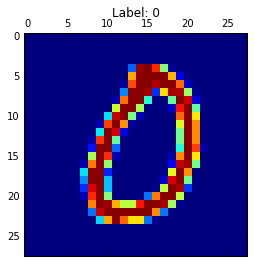

In [7]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
# ax.imshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

In [8]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  
  # There are 784 pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [9]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
        
#     tf.estimator.inputs.numpy_input_fn(               x={"x": train_data},
#                                                       y=train_labels,
#                                                       batch_size=batch_
        
        
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"x":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [10]:
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"x": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [11]:
def cnn_model_fn(features, labels, mode, params):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
#     optimizer = tf.train.AdagradOptimizer(learning_rate=0.05)
#     optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
#     optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=params["learning_rate"])#learning_rate=0.001)
    optimizer = params["optimizer"]
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [12]:
def train_cnn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, as well as a confusion
  matrix.
  
  Args:
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `CNNClassifier` object.
  """
#log to terminal
  tf.logging.set_verbosity(tf.logging.INFO)
    # Set up logging for predictions
    # Log the values in the "Softmax" tensor with label "probabilities"
  tensors_to_log = {"probabilities": "softmax_tensor"}
  logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)

  periods = 10
  # Caution: input pipelines are reset with each call to train. 
  # If the number of steps is small, your model may never see most of the data.  
  # So with multiple `.train` calls like this you may want to control the length 
  # of training with num_epochs passed to the input_fn. Or, you can do a really-big shuffle, 
  # or since it's in-memory data, shuffle all the data in the `input_fn`.
  steps_per_period = steps / periods  
  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)

  # Create feature columns.
#   feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

  # Create a CNNClassifier object. ### Optimzer in cnn_model #####
#   my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
#   my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

#   my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.05)
#   my_optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
#   my_optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

  # Create the Estimator                        ## ADDED params so that I can pass values to model
  classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_mode7", params={
        'learning_rate': learning_rate,
        'optimizer' : my_optimizer,
#         'feature_columns': my_feature_columns,
#         # Two hidden layers of 10 nodes each.
#         'hidden_units': [10, 10],
#         # The model must choose between 3 classes.
#         'n_classes': 3,
    })

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error and accuracy (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
  # Train the model, starting from the prior state.

  # Train the model
    classifier.train(
          input_fn=training_input_fn,
          steps=steps_per_period,#,#000,#20000,
          hooks=[logging_hook]
        )
    
    eval_results = classifier.evaluate(input_fn=predict_validation_input_fn)
    print(eval_results)
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_pred_class_id = np.array([item['classes'] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
       
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn)) 
    validation_pred_class_id = np.array([item['classes'] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)   
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f     Accuracy: %02f" % (period, validation_log_loss, eval_results['accuracy']))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['classes'] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

Training model...
LogLoss error and accuracy (on validation data):
{'global_step': 2000, 'loss': 0.5867178, 'accuracy': 0.8512}
  period 00 : 5.14     Accuracy: 0.851200
{'global_step': 4000, 'loss': 0.31157228, 'accuracy': 0.912}
  period 01 : 3.04     Accuracy: 0.912000
{'global_step': 6000, 'loss': 0.24010241, 'accuracy': 0.9316}
  period 02 : 2.36     Accuracy: 0.931600
{'global_step': 8000, 'loss': 0.2011945, 'accuracy': 0.94}
  period 03 : 2.07     Accuracy: 0.940000
{'global_step': 10000, 'loss': 0.17659006, 'accuracy': 0.9472}
  period 04 : 1.82     Accuracy: 0.947200
{'global_step': 12000, 'loss': 0.15939787, 'accuracy': 0.9496}
  period 05 : 1.74     Accuracy: 0.949600
{'global_step': 14000, 'loss': 0.145344, 'accuracy': 0.9552}
  period 06 : 1.55     Accuracy: 0.955200
{'global_step': 16000, 'loss': 0.1326399, 'accuracy': 0.9576}
  period 07 : 1.46     Accuracy: 0.957600
{'global_step': 18000, 'loss': 0.12371579, 'accuracy': 0.9608}
  period 08 : 1.35     Accuracy: 0.960800


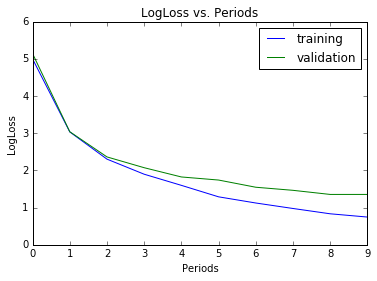

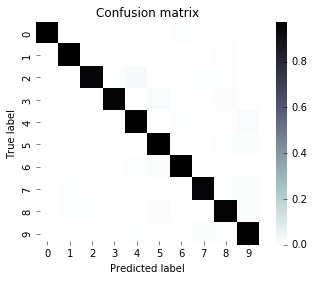

In [13]:
cnn_classifier = train_cnn_classification_model(
    learning_rate=0.001,#0.05,
    steps=20000,#1000,
    batch_size=100,
    hidden_units=[5],#[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [14]:
mnist_test_dataframe = pd.read_csv(
  "data/test.csv",
  sep=",")

mnist_test_sample_dataframe = pd.read_csv(
  "data/sample_submission.csv",
  sep=",")

# test_targets, test_examples = parse_test_labels_and_features(mnist_test_sample_dataframe, mnist_test_dataframe)#parse_labels_and_features(mnist_test_dataframe)


# test_examples =   features = dataset.iloc[:,1:785]
  # Scale the data to [0, 1] by dividing out the max value, 255.
#   features = features // 255
#   features = features.applymap(lambda x: x / 255)

test_examples = mnist_test_dataframe.copy().applymap(lambda x: x / 255)
# print(mnist_test_sample_dataframe)
test_targets = mnist_test_sample_dataframe['Label'].copy()
test_examples.describe()
# test_targets.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.7,0.5,0.0,0.0,0.0,0.0,0.0


In [15]:
predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size=100)

test_predictions = cnn_classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['classes'] for item in test_predictions])
  
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

Accuracy on test data: 0.10


In [16]:
print(len(test_predictions))
new = pd.DataFrame(test_predictions, columns=["Label"])#[1], index=new_predictions[0])
# print(new)
# new.index.name = "ImageId"
new = pd.concat([mnist_test_sample_dataframe['ImageId'], new], axis=1)
print(new)

28000
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [17]:
new.to_csv('predictions7.csv', index=False)

In [18]:
# ## Visualize weights of first hidden layer
# print(cnn_classifier.get_variable_names())

# weights0 = cnn_classifier.get_variable_value("/tmp/mnist_convnet_mode2/hiddenlayer_0/kernel");#dnn/hiddenlayer_0/kernel")

# print("weights0 shape:", weights0.shape)

# num_nodes = weights0.shape[1]
# num_rows = int(math.ceil(num_nodes / 10.0))
# fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
# for coef, ax in zip(weights0.T, axes.ravel()):
#     # Weights in coef is reshaped from 1x784 to 28x28.
#     ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
#     ax.set_xticks(())
#     ax.set_yticks(())

# plt.show()

In [19]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# import numpy as np
# import tensorflow as tf
# import pandas as pd
# from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# tf.logging.set_verbosity(tf.logging.INFO)

In [20]:
# def cnn_model_fn(features, labels, mode):
#   """Model function for CNN."""
#   # Input Layer
#   # Reshape X to 4-D tensor: [batch_size, width, height, channels]
#   # MNIST images are 28x28 pixels, and have one color channel
#   input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

#   # Convolutional Layer #1
#   # Computes 32 features using a 5x5 filter with ReLU activation.
#   # Padding is added to preserve width and height.
#   # Input Tensor Shape: [batch_size, 28, 28, 1]
#   # Output Tensor Shape: [batch_size, 28, 28, 32]
#   conv1 = tf.layers.conv2d(
#       inputs=input_layer,
#       filters=32,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)

#   # Pooling Layer #1
#   # First max pooling layer with a 2x2 filter and stride of 2
#   # Input Tensor Shape: [batch_size, 28, 28, 32]
#   # Output Tensor Shape: [batch_size, 14, 14, 32]
#   pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

#   # Convolutional Layer #2
#   # Computes 64 features using a 5x5 filter.
#   # Padding is added to preserve width and height.
#   # Input Tensor Shape: [batch_size, 14, 14, 32]
#   # Output Tensor Shape: [batch_size, 14, 14, 64]
#   conv2 = tf.layers.conv2d(
#       inputs=pool1,
#       filters=64,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)

#   # Pooling Layer #2
#   # Second max pooling layer with a 2x2 filter and stride of 2
#   # Input Tensor Shape: [batch_size, 14, 14, 64]
#   # Output Tensor Shape: [batch_size, 7, 7, 64]
#   pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#   # Flatten tensor into a batch of vectors
#   # Input Tensor Shape: [batch_size, 7, 7, 64]
#   # Output Tensor Shape: [batch_size, 7 * 7 * 64]
#   pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

#   # Dense Layer
#   # Densely connected layer with 1024 neurons
#   # Input Tensor Shape: [batch_size, 7 * 7 * 64]
#   # Output Tensor Shape: [batch_size, 1024]
#   dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

#   # Add dropout operation; 0.6 probability that element will be kept
#   dropout = tf.layers.dropout(
#       inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

#   # Logits layer
#   # Input Tensor Shape: [batch_size, 1024]
#   # Output Tensor Shape: [batch_size, 10]
#   logits = tf.layers.dense(inputs=dropout, units=10)

#   predictions = {
#       # Generate predictions (for PREDICT and EVAL mode)
#       "classes": tf.argmax(input=logits, axis=1),
#       # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
#       # `logging_hook`.
#       "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
#   }
#   if mode == tf.estimator.ModeKeys.PREDICT:
#     return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

#   # Calculate Loss (for both TRAIN and EVAL modes)
#   loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

#   # Configure the Training Op (for TRAIN mode)
#   if mode == tf.estimator.ModeKeys.TRAIN:
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
#     train_op = optimizer.minimize(
#         loss=loss,
#         global_step=tf.train.get_global_step())
#     return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

#   # Add evaluation metrics (for EVAL mode)
#   eval_metric_ops = {
#       "accuracy": tf.metrics.accuracy(
#           labels=labels, predictions=predictions["classes"])}
#   return tf.estimator.EstimatorSpec(
#       mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [21]:
# # def main(unused_argv):
# # Load training and eval data
# VALID = 10000 # Validation data size

# LABELS = 10 # Number of different types of labels (1-10)
# WIDTH = 28 # width / height of the image
# CHANNELS = 1 # Number of colors in the image (greyscale)
# data = pd.read_csv('data/train.csv') # Read csv file in pandas dataframe
# labels = np.array(data.pop('label')) # Remove the labels as a numpy array from the dataframe
# #   labels = LabelEncoder().fit_transform(labels)[:, None]
# #   labels = OneHotEncoder().fit_transform(labels).todense()
# data = StandardScaler().fit_transform(np.float32(data.values)) # Convert the dataframe to a numpy array
# #   data = data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images
# train_data, eval_data = data[:-VALID], data[-VALID:]
# train_labels, eval_labels = labels[:-VALID], labels[-VALID:]

# train_data

In [22]:



# #   mnist = tf.contrib.learn.datasets.load_dataset("mnist")
# #   train_data = mnist.train.images  # Returns np.array
# #   train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
# #   eval_data = mnist.test.images  # Returns np.array
# #   eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

# # Create the Estimator
# mnist_classifier = tf.estimator.Estimator(
#   model_fn=cnn_model_fn, model_dir="~/delete/one")#/tmp/mnist_convnet_model")

# # # Set up logging for predictions
# # # Log the values in the "Softmax" tensor with label "probabilities"
# # tensors_to_log = {"probabilities": "softmax_tensor"}
# # logging_hook = tf.train.LoggingTensorHook(
# #   tensors=tensors_to_log, every_n_iter=50)

# # Train the model
# train_input_fn = tf.estimator.inputs.numpy_input_fn(
#   x={"x": train_data},
#   y=train_labels,
#   batch_size=100,
#   num_epochs=None,
#   shuffle=True)
# mnist_classifier.train(
#   input_fn=train_input_fn,
#   steps=5#,#000,#20000,
# #   hooks=[logging_hook]
# )

# # Evaluate the model and print results
# eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#   x={"x": eval_data},
#   y=eval_labels,
#   num_epochs=1,
#   shuffle=False)
# eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
# print(eval_results)

In [23]:
# #  Copyright 2016 The TensorFlow Authors. All Rights Reserved.
# #
# #  Licensed under the Apache License, Version 2.0 (the "License");
# #  you may not use this file except in compliance with the License.
# #  You may obtain a copy of the License at
# #
# #   http://www.apache.org/licenses/LICENSE-2.0
# #
# #  Unless required by applicable law or agreed to in writing, software
# #  distributed under the License is distributed on an "AS IS" BASIS,
# #  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# #  See the License for the specific language governing permissions and
# #  limitations under the License.
# """Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# import numpy as np
# import tensorflow as tf

# tf.logging.set_verbosity(tf.logging.INFO)


# def cnn_model_fn(features, labels, mode):
#   """Model function for CNN."""
#   # Input Layer
#   # Reshape X to 4-D tensor: [batch_size, width, height, channels]
#   # MNIST images are 28x28 pixels, and have one color channel
#   input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

#   # Convolutional Layer #1
#   # Computes 32 features using a 5x5 filter with ReLU activation.
#   # Padding is added to preserve width and height.
#   # Input Tensor Shape: [batch_size, 28, 28, 1]
#   # Output Tensor Shape: [batch_size, 28, 28, 32]
#   conv1 = tf.layers.conv2d(
#       inputs=input_layer,
#       filters=32,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)

#   # Pooling Layer #1
#   # First max pooling layer with a 2x2 filter and stride of 2
#   # Input Tensor Shape: [batch_size, 28, 28, 32]
#   # Output Tensor Shape: [batch_size, 14, 14, 32]
#   pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

#   # Convolutional Layer #2
#   # Computes 64 features using a 5x5 filter.
#   # Padding is added to preserve width and height.
#   # Input Tensor Shape: [batch_size, 14, 14, 32]
#   # Output Tensor Shape: [batch_size, 14, 14, 64]
#   conv2 = tf.layers.conv2d(
#       inputs=pool1,
#       filters=64,
#       kernel_size=[5, 5],
#       padding="same",
#       activation=tf.nn.relu)

#   # Pooling Layer #2
#   # Second max pooling layer with a 2x2 filter and stride of 2
#   # Input Tensor Shape: [batch_size, 14, 14, 64]
#   # Output Tensor Shape: [batch_size, 7, 7, 64]
#   pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#   # Flatten tensor into a batch of vectors
#   # Input Tensor Shape: [batch_size, 7, 7, 64]
#   # Output Tensor Shape: [batch_size, 7 * 7 * 64]
#   pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

#   # Dense Layer
#   # Densely connected layer with 1024 neurons
#   # Input Tensor Shape: [batch_size, 7 * 7 * 64]
#   # Output Tensor Shape: [batch_size, 1024]
#   dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

#   # Add dropout operation; 0.6 probability that element will be kept
#   dropout = tf.layers.dropout(
#       inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

#   # Logits layer
#   # Input Tensor Shape: [batch_size, 1024]
#   # Output Tensor Shape: [batch_size, 10]
#   logits = tf.layers.dense(inputs=dropout, units=10)

#   predictions = {
#       # Generate predictions (for PREDICT and EVAL mode)
#       "classes": tf.argmax(input=logits, axis=1),
#       # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
#       # `logging_hook`.
#       "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
#   }
#   if mode == tf.estimator.ModeKeys.PREDICT:
#     return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

#   # Calculate Loss (for both TRAIN and EVAL modes)
#   loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

#   # Configure the Training Op (for TRAIN mode)
#   if mode == tf.estimator.ModeKeys.TRAIN:
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
#     train_op = optimizer.minimize(
#         loss=loss,
#         global_step=tf.train.get_global_step())
#     return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

#   # Add evaluation metrics (for EVAL mode)
#   eval_metric_ops = {
#       "accuracy": tf.metrics.accuracy(
#           labels=labels, predictions=predictions["classes"])}
#   return tf.estimator.EstimatorSpec(
#       mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


# def main(unused_argv):
#   # Load training and eval data
#   mnist = tf.contrib.learn.datasets.load_dataset("mnist")
#   train_data = mnist.train.images  # Returns np.array
#   train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
#   eval_data = mnist.test.images  # Returns np.array
#   eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

#   # Create the Estimator
#   mnist_classifier = tf.estimator.Estimator(
#       model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

#   # Set up logging for predictions
#   # Log the values in the "Softmax" tensor with label "probabilities"
#   tensors_to_log = {"probabilities": "softmax_tensor"}
#   logging_hook = tf.train.LoggingTensorHook(
#       tensors=tensors_to_log, every_n_iter=50)

#   # Train the model
#   train_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": train_data},
#       y=train_labels,
#       batch_size=100,
#       num_epochs=None,
#       shuffle=True)
#   mnist_classifier.train(
#       input_fn=train_input_fn,
#       steps=20000,
#       hooks=[logging_hook])

#   # Evaluate the model and print results
#   eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": eval_data},
#       y=eval_labels,
#       num_epochs=1,
#       shuffle=False)
#   eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
#   print(eval_results)


# if __name__ == "__main__":
#   tf.app.run()